In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Flatten, Dense
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
from tensorflow.keras.layers.experimental import preprocessing
from risk_model import Model
from datetime import datetime

import plotly.graph_objects as go
from pandas_datareader import data as pdr
%matplotlib inline

from absl import logging
tf.get_logger().setLevel('ERROR')

float_formatter = "{:.4f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
tf.random.set_seed(123)

np.random.seed(123)
yf.pdr_override()  # <== that's all it takes :-)


very_small_float = 1.0 #0.000000001

2022-09-17 21:50:01.445118: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-17 21:50:01.445222: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from bt_testcode import backtest, DynRebalance, get_name, plotAllocation, getStatistic, calc_portfolio_values
from bt_testcode import plotPortfolioReturns, get_portfolio_values

# Test Model

In [3]:
ticker = """AXISBANK.NS	BPCL.NS	BRITANNIA.NS	CIPLA.NS	DRREDDY.NS	EICHERMOT.NS	GAIL.NS	HDFCBANK.NS	HINDALCO.NS	HINDUNILVR.NS	INFY.NS	IOC.NS	ITC.NS	M&M.NS	MARICO.NS	ONGC.NS	RELIANCE.NS	SAIL.NS	SBIN.NS	SIEMENS.NS	SUNPHARMA.NS	TATACONSUM.NS	TATAMOTORS.NS	TATAPOWER.NS	TATASTEEL.NS	TITAN.NS VEDL.NS	WIPRO.NS""".split()
benchmark_index = "^BSESN"
history_range = {'start': datetime(2000, 1, 1), 
                 'end': datetime(2022, 9, 30)}

stock = pdr.DataReader(ticker, 
                start=history_range['start'],
                end=history_range['end'],
                data_source='yahoo')

[*********************100%***********************]  28 of 28 completed


In [4]:
stock_close = stock.iloc[:]['Close'].reset_index(drop=True).fillna(very_small_float)
stock_close.head()

,AXISBANK.NS,BPCL.NS,BRITANNIA.NS,CIPLA.NS,DRREDDY.NS,EICHERMOT.NS,GAIL.NS,HDFCBANK.NS,HINDALCO.NS,HINDUNILVR.NS,...,SBIN.NS,SIEMENS.NS,SUNPHARMA.NS,TATACONSUM.NS,TATAMOTORS.NS,TATAPOWER.NS,TATASTEEL.NS,TITAN.NS,VEDL.NS,WIPRO.NS
0,5.18,33.270832,75.690002,116.587997,377.062500,4.885,8.587504,17.000000,73.833130,230.755005,...,22.988886,54.494999,14.214153,56.450001,41.535931,7.406506,8.559305,7.7850,2.90875,102.157501
1,5.38,30.875000,75.455002,117.220001,407.237488,5.140,8.293754,17.379999,76.633423,228.104996,...,24.446625,54.654999,14.023603,55.090000,39.897491,7.420981,8.466666,7.3700,2.86750,110.330627
2,5.24,29.995832,73.529999,114.804001,392.012512,5.555,7.900003,16.695000,82.761711,219.990005,...,23.441774,52.250000,13.531350,52.794998,40.865227,7.565734,8.789500,6.9200,2.85000,112.128754
3,5.11,31.691666,78.565002,108.468002,415.387512,6.000,8.118754,16.830000,89.238976,228.820007,...,24.625893,53.000000,13.518182,54.560001,42.561157,7.802163,9.446396,7.4750,2.98250,109.959381
4,4.86,31.654165,84.849998,99.804001,382.274994,6.465,7.831253,16.834999,93.196831,241.294998,...,25.786425,48.779999,12.436851,58.910000,45.972179,7.787688,9.654133,7.3175,2.91250,101.163757


In [5]:
import matplotlib.pyplot as plt
rnd = 8
tf.random.set_seed(rnd)
np.random.seed(rnd)

param={}
param ={'model_params':
    {'model_n':'LSTM',
    'epochs':10}}

m = Model()
alloc = m.get_allocations(stock_close.values, **param['model_params'])


2022-09-17 21:50:27.812434: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-17 21:50:27.812481: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-17 21:50:27.812510: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (divyanshu-PC): /proc/driver/nvidia/version does not exist


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

/home/divyanshu/Documents/GitHub/BTP/lib/python3.10/site-packages/riskfolio/PlotFunctions.py:568: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sizes2 = sizes2.append(item)


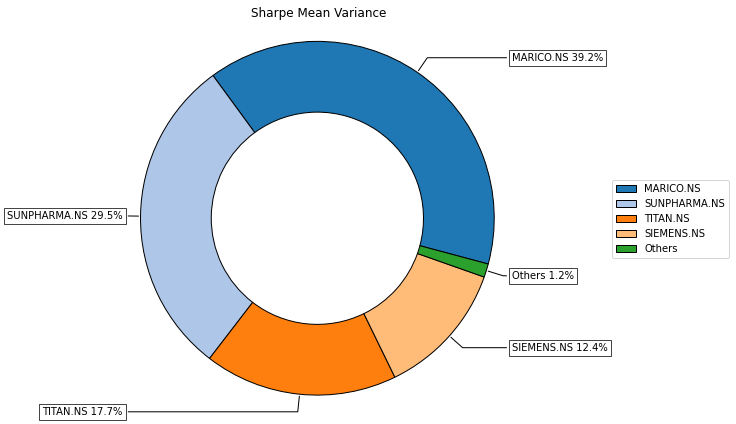

In [6]:
import riskfolio as rp
df = pd.DataFrame(alloc, index=ticker)
ax = rp.plot_pie(w=df, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap="tab20",
                 height=6, width=10, ax=None)

In [7]:
calc_portfolio_values(alloc, stock_close)

portfolio_returns: 5.6928
std: 0.0147
sharpe: 0.0683


In [8]:
index = stock.groupby(
    [stock.index.year, stock.index.month]).tail(1).index
index_2 = stock.index

# Quarterly Dates
index = [x for x in index if float(x.month) % 3.0 == 0]

# Dates where the strategy will be backtested
index_ = [index_2.get_loc(x) for x in index if index_2.get_loc(x) > 1000]
print(index_)


[1042, 1107, 1172, 1238, 1304, 1365, 1429, 1493, 1554, 1615, 1676, 1740, 1801, 1861, 1923, 1987, 2049, 2111, 2172, 2236, 2295, 2353, 2413, 2477, 2538, 2597, 2660, 2725, 2788, 2850, 2912, 2975, 3034, 3096, 3158, 3220, 3279, 3341, 3403, 3466, 3527, 3589, 3650, 3713, 3771, 3832, 3893, 3957, 4017, 4078, 4140, 4202, 4263, 4325, 4386, 4449, 4511, 4571, 4635, 4696, 4757, 4817, 4877, 4939, 5000, 5063, 5122, 5188, 5251, 5312, 5373, 5436, 5499, 5560, 5622, 5675]


In [9]:

from IPython.display import clear_output


from tqdm.notebook import trange, tqdm
n = index_[:-1]

def getReturnFromAlloc(n):
    r_list = []
    param={}
    param ={'model_params':
        {'model_n':'LSTM',
        'epochs':100}}
    print('ret, std, sharp')
    for i in tqdm(n):
        stock_close = stock.iloc[i:i+125]['Close'].reset_index(drop=True).fillna(very_small_float)
        m = Model()
        alloc = m.get_allocations(stock_close.values, **param['model_params'])
        r_list.append((get_portfolio_values(alloc, stock_close)))
        #print(r_list[-1])
        #clear_output(wait=True)
    return r_list

rl = getReturnFromAlloc(n)
sharp = []
for r, s, sp in rl:
    print("{:.4f}  {:.4f}  {:.4f}".format(r,s,sp))
    sharp.append(sp)


ret, std, sharp


  0%|          | 0/75 [00:00<?, ?it/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

KeyboardInterrupt: 

In [10]:
config_cerebro = {
    'assets': ticker,
    #'assets':['SPY', 'TLT', 'GLD', 'BA', 'SLV', 'WYNN','MO', 'AEE', 'AIG', 'WY'],
    'benchmark': benchmark_index,
    'startd': history_range['start'],
    'endd': history_range['end'],
    'set_coc' : True,
    'set_coo' : False,
    'cash': 1000000.0,
    'stocks_df':None,
    'benchmark_df':None
}

params = {
    'DataCounter': 125,
    'RebalanceDay': 22,
    'reserveCash': 1000.0,
    'printlog': 0,
    'benchmarkUse': True,
    'resetModel':False, 
    'resetModelStep':4,
    'model':Model(),
    'model_params':{
        'model_n':'LSTM',
        'collectData':False,
        'epochs':100}
}
d_res = {}
d_stat = {}

config_cerebro['stocks_df'] = pdr.DataReader(config_cerebro['assets'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')
config_cerebro['benchmark_df'] = pdr.DataReader(config_cerebro['benchmark'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')

[*********************100%***********************]  28 of 28 completed
[*********************100%***********************]  1 of 1 completed


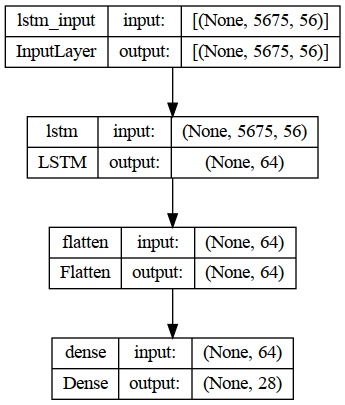

In [11]:
tf.keras.utils.plot_model(m.getModel(), show_shapes=True)


Starting Portfolio Value: 1000000.00


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

KeyboardInterrupt: 

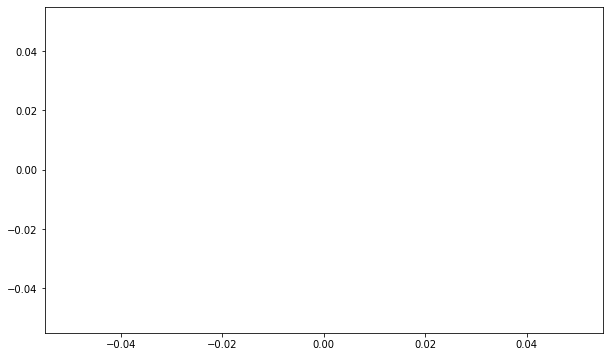

In [12]:
import matplotlib.pyplot as plt
params['model'] = Model()
params['resetModel'] = False
%matplotlib inline

plt.rcParams["figure.figsize"] = (10, 6)  # (w, h)
plt.plot()
d_stat[get_name(params)], d_res[get_name(params)], ah = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)
display(d_stat[get_name(params)])
d_res[get_name(params)].plot()